In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import time
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import float32, zeros, ones, eye, as_tensor, tensor

from sbi.inference import MCMCPosterior, VIPosterior, ImportanceSamplingPosterior
from sbi.analysis import pairplot
from sbi.utils import mcmc_transform

from gbi.GBI import GBInference
from gbi.hh.train_gbi import MaeDistZ
import gbi.hh.utils as utils
from gbi.hh.HodgkinHuxley import HodgkinHuxley
from gbi.hh.HodgkinHuxleyStatsMoments import HodgkinHuxleyStatsMoments

### Main figure is with 1 Million simulations

In [3]:
gbi_path = "/home/michael/Documents/neuralgbi/results/hh/gbi/2023_05_05__09_51_04_m/0_nsims_10000"
npe_path = "/home/michael/Documents/neuralgbi/results/hh/gbi/2023_05_05__09_51_04_m/0_nsims_10000"

In [3]:
with open(f"{gbi_path}/inference_gbi.pkl", "rb") as handle:
    inference_gbi = pickle.load(handle)
with open(f"{npe_path}/inference_npe.pkl", "rb") as handle:
    inference_npe = pickle.load(handle)

AttributeError: Can't get attribute 'MaeDistZ' on <module '__main__'>

### Load simulator

In [ ]:
I, t_on, t_off, dt = utils.syn_current()
obs = utils.syn_obs_data(I, dt, true_params, seed=seed, cython=True)

sim = HodgkinHuxley(
    I, dt, V0=obs["data"][0], reduced_model=False, cython=True, prior_log=False
)
stats = HodgkinHuxleyStatsMoments(
    t_on=t_on, t_off=t_off, n_xcorr=n_xcorr, n_mom=n_mom, n_summary=n_summary
)

### Load prior

In [ ]:
true_params, labels_params = utils.obs_params(reduced_model=False)
prior = utils.prior(
    true_params=true_params,
    prior_uniform=True,
    prior_extent=True,
    prior_log=False,
    seed=0,
)
limits = torch.stack(
    [
        prior.support.base_constraint.lower_bound,
        prior.support.base_constraint.upper_bound,
    ]
).T

### Load allen cell data

In [33]:
seed = 1
n_xcorr = 0
n_mom = 4
n_summary = 7

In [29]:
# list of all Allen recordings
list_cells_AllenDB = [[518290966,57,0.0234/126],[509881736,39,0.0153/184],[566517779,46,0.0195/198],
                      [567399060,38,0.0259/161],[569469018,44,0.033/403],[532571720,42,0.0139/127],
                      [555060623,34,0.0294/320],[534524026,29,0.027/209],[532355382,33,0.0199/230],
                      [526950199,37,0.0186/218]]

n_cells = len(list_cells_AllenDB)

# define model, summary statistics and generator
obs_stats_ls = []
m_ls = []
s_ls = []
g_ls = []
all_obs = []
for cell_num in range(n_cells):
    ephys_cell = list_cells_AllenDB[cell_num][0]
    sweep_number = list_cells_AllenDB[cell_num][1]
    A_soma = list_cells_AllenDB[cell_num][2]
    junction_potential = -14

    obs = utils.allen_obs_data(ephys_cell=ephys_cell,sweep_number=sweep_number,A_soma=A_soma)
    all_obs.append(obs)

    obs['data'] = obs['data'] + junction_potential
    I = obs['I']
    dt = obs['dt']
    t_on = obs['t_on']
    t_off = obs['t_off']

    obs_stats = utils.allen_obs_stats(data=obs,ephys_cell=ephys_cell,sweep_number=sweep_number,
                                      n_xcorr=n_xcorr,n_mom=n_mom,
                                      n_summary=n_summary)
    obs_stats_ls.append(obs_stats)

In [30]:
with open("data/theta.pkl", "rb") as handle:
    theta = pickle.load(handle)

with open("data/summstats.pkl", "rb") as handle:
    x = pickle.load(handle)

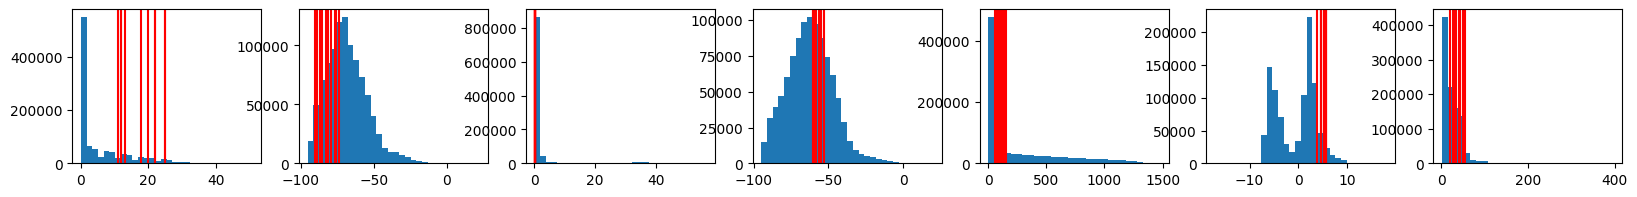

In [31]:
fig, ax = plt.subplots(1, 7, figsize=(20, 2))
for i in range(7):
    _ = ax[i].hist(x[:, i].numpy(), bins=30)
    for o in obs_stats_ls:
        ax[i].axvline(o[0, i], c="r")

# GBI

### Evaluate the distance estimator

In [ ]:
# Generate, for 10 simulations for 100 thetas
theta_vals = prior.sample((100,))
seeds = torch.randint(0, 100000, (100, 10))
final_stats = []
for theta_ind, theta_val in enumerate(theta_vals):
    all_summstats = []
    for iter_ in range(10):  # 10 sims per theta
        x_val = sim.gen_single(theta, seed=seeds[theta_ind, iter_])
        summstats = stats([x_val])
        all_summstats.append(summstats)
    final_stats.append(all_summstats)

final_stats = np.asarray(final_stats)

In [ ]:
# Generate 10 synthetic observations
theta_vals = prior.sample((10,))
seeds = torch.randint(0, 100000, (10,))
x_target_vals = []
for theta_ind, theta_val in enumerate(theta_vals):
    x_val = sim.gen_single(theta, seed=seeds[theta_ind])
    summstats = stats([x_val])
    x_target_vals.append(summstats)

x_target_vals = np.asarray(x_target_vals)

In [ ]:
pred_dists = [distance_net.forward(theta_vals, x_target_val).detach().numpy() for x_target_val in x_target_vals]
true_dists = [inference_gbi.distance_func(final_stats, x_target_val).numpy() for x_target_val in x_target_vals]

In [ ]:
cols = [
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
    "#6a3d9a",
]
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 8, figsize=(6, 4))
    for i in range(10):
        t = true_dists[i]
        p = pred_dists[i]
        _ = ax.scatter(t, p, c=cols[i], alpha=.3)
        _ = ax.set_xlabel("True dist")
        _ = ax.set_ylabel("Pred dist")
    plt.savefig("svg/panel_aa.svg")

### Draw samples from posterior

In [ ]:
def sample_gbi_all_xo(beta):
    all_samples = []
    for xo in obs_stats_ls:
        xo = as_tensor(xo)
        potential_fn = inference_gbi.get_potential(x_o=xo, beta=beta)
        theta_transform = mcmc_transform(prior)

        posterior = MCMCPosterior(
            potential_fn,
            theta_transform=theta_transform,
            proposal=prior,
            method="slice_np_vectorized",
            thin=10,
            warmup_steps=100,
            num_chains=100,
            init_strategy="resample",
            frac_chains_to_finish=0.9,
        )
        posterior_samples = posterior.sample((1_000,), frac_chains_to_finish=0.9)
        all_samples.append(posterior_samples)
    return all_samples

In [ ]:
betas = [10.0, 50.0, 250.0]

In [ ]:
samples_gbi_beta10 = sample_gbi_all_xo(betas[0])
samples_gbi_beta50 = sample_gbi_all_xo(betas[1])
samples_gbi_beta250 = sample_gbi_all_xo(betas[2])
with open("samples_gbi_beta10.pkl", "wb") as handle:
    pickle.dump(samples_gbi_beta10, handle)
with open("samples_gbi_beta50.pkl", "wb") as handle:
    pickle.dump(samples_gbi_beta50, handle)
with open("samples_gbi_beta250.pkl", "wb") as handle:
    pickle.dump(samples_gbi_beta250, handle)

In [ ]:
with open("samples_gbi_beta10.pkl", "rb") as handle:
    samples_gbi_beta10 = pickle.load(handle)
with open("samples_gbi_beta50.pkl", "rb") as handle:
    samples_gbi_beta50 = pickle.load(handle)
with open("samples_gbi_beta250.pkl", "rb") as handle:
    samples_gbi_beta250 = pickle.load(handle)

### Posterior predictives

In [ ]:
all_predictives_gbi250 = []
for posterior_samples in samples_gbi_beta250:
    r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples]
    all_predictives_gbi250.append(r)

all_predictives_gbi50 = []
for posterior_samples in samples_gbi_beta50:
    r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples]
    all_predictives_gbi50.append(r)

all_predictives_gbi10 = []
for posterior_samples in samples_gbi_beta10:
    r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples]
    all_predictives_gbi10.append(r)

In [ ]:
gbi250_av_dists = []
for predictives, xo in zip(all_predictives_gbi250, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    gbi250_av_dists.append(torch.mean(dists))

gbi50_av_dists = []
for predictives, xo in zip(all_predictives_gbi50, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    gbi50_av_dists.append(torch.mean(dists))

gbi10_av_dists = []
for predictives, xo in zip(all_predictives_gbi10, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    gbi10_av_dists.append(torch.mean(dists))

In [ ]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 8, figsize=(6, 4))
    for i in range(8):
        predictives = all_predictives_gbi250[i]
        xo  = all_obs[i]
        for p in predictives:
            _ = ax[i].plot(p["data"], c="grey", alpha=0.4)
        _ = ax[i].plot(xo["data"], c="k")
        _ = ax[i].set_xlabel("Index")
        _ = ax[i].set_ylabel("Voltage (mV)")
        plt.savefig("svg/panel_b.svg")

# NPE

In [ ]:
npe_all_samples = []
for xo in obs_stats_ls:
    xo = as_tensor(xo)
    posterior = inference_npe.build_posterior()
    posterior_samples = posterior.sample((1_000,), x=xo)
    npe_all_samples.append(posterior_samples)

In [ ]:
all_predictives = []
for posterior_samples in npe_all_samples:
    r = [sim.gen_single(theta.numpy(), seed=0) for theta in posterior_samples]
    all_predictives.append(r)

In [ ]:
npe_av_dists = []
for predictives, xo in zip(all_predictives, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    npe_av_dists.append(torch.mean(dists))

In [ ]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 8, figsize=(6, 4))
    for i in range(8):
        predictives = all_predictives[i]
        xo  = all_obs[i]
        for p in predictives:
            _ = ax[i].plot(p["data"], c="grey", alpha=0.4)
        _ = ax[i].plot(xo["data"], c="k")
        _ = ax[i].set_xlabel("Index")
        _ = ax[i].set_ylabel("Voltage (mV)")
        plt.savefig("svg/panel_a.svg")

# Compare NPE and GBI

In [ ]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    _ = ax.scatter([0], [np.mean(npe_av_dists)], c="k")
    _ = ax.plot([1, 2, 3], [np.mean(gbi10_av_dists), np.mean(gbi50_av_dists), np.mean(gbi250_av_dists)])
    plt.savefig("svg/panel_c.svg")

In [ ]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = pairplot(
        [
            npe_all_samples[0], 
            samples_gbi_beta10[0], 
            samples_gbi_beta50[0], 
            samples_gbi_beta250[0], 
        ],
        limits=limits,
        ticks=limits,
        upper="contour",
        contour_offdiag={"levels": [0.68], "percentile": True},
        figsize=(6, 6),
    )
    _ = ax.set_title(f"ID {list_cells_AllenDB[0][0]}")
    plt.savefig("svg/panel_d.svg")

### Assemble figure

In [34]:
import time
import IPython.display as IPd
from svgutils.compose import *

In [ ]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}

f = Figure("15.3cm", "7.1cm",
           
    Panel(
          SVG("../svg/illustration.svg").scale(svg_scale),
          Text("a", -5, 2.0, **kwargs_text),
    ).move(10, 20),
           
    Panel(
          SVG("../svg/panel_a.svg").scale(svg_scale),
          Text("b", -5, 2.0, **kwargs_text),
    ).move(10, 20),
    
    Panel(
          SVG("../svg/panel_b.svg").scale(svg_scale),
          Text("c", -5, 2.0, **kwargs_text),
    ).move(400, 20),
           
    Panel(
          SVG("../svg/panel_c.svg").scale(svg_scale),
          Text("d", -5, 2.0, **kwargs_text),
    ).move(400, 20),
           
    Panel(
          SVG("../svg/panel_d.svg").scale(svg_scale),
          Text("e", -5, 2.0, **kwargs_text),
    ).move(400, 20),
)

!mkdir -p fig
f.save("fig/fig.svg")
svg("fig/fig.svg")